# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.preprocessing_strategy_transformers as scjpnpreprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy
import io

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
n_exp = 0
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        n_exp += 1
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity}) \\in O(n^" + "{" + f"{n_exp}" + "})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"In our case, this would amount to {cartesian_prod} iterations doing it the brute-force way!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|amount_tsh|\times |pump_age|\times |funder|\times |gps_height|\times |installer|\times |latitude|\times |longitude|\times |wpt_name|\times |num_private|\times |basin|\times |region_code|\times |district_code|\times |region|\times |lga|\times |ward|\times |subvillage|\times |population|\times |public_meeting|\times |recorded_by|\times |scheme_management|\times |scheme_name|\times |permit|\times |extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |management|\times |management_group|\times |payment_type|\times |payment|\times |water_quality|\times |quality_group|\times |quantity|\times |quantity_group|\times |source|\times |source_type|\times |source_class|\times |waterpoint_type|\times |waterpoint_type_group|) \in O(n^{38})$

In our case, this would amount to 78991077408768 iterations doing it the brute-force way!)

You read that correctly: if we do this using brute-force, that would require building (transforming) a virtually uncountable number of data sets.

That is obviously intractible.  

Consider the case when transforming and building a model on X_train and predicting on X_validation takes, on average, 1 minute.

There are 525600 minutes in one year.

In [17]:
display(HTML(f"Doing it the brute-force way (the space of all possible combinations of preprocessing options) would require about {int((cartesian_prod/525600)/1000000)} MILLION years!!!"))

Instead, we will use a Greedy Algorithm to turn this into a linear problem.

But first, some detail on "baselining" and justification are required.

## Baselining "Theory" - Dynamic Programming Approach

The basic idea behind this approach is to use a muticlassification algorithm to build a basic model with the most features possible from the raw data set (prior to any transformations).

From there, we iterate through each feature-group.  Note that features are grouped and related by their descriptions (and analysis conducted in EDA).

Thus, each feature-group consists of a set of features that are related semantically (but necessarily in form/data type).

For each (related) feature within a feature-group, a feature has a set of applicable preprocessing "options".  These are the collective set of possible transformations that can be done to the feature, derived from the findings of the analysis conducted within [EDA.ipynb](EDA.ipynb).

So, in theory, for each feature, we iterate through all possible preprocessing options (ordered by preference - e.g. first consider the "Drop it" strategy, then the "leave it as is" strategy, etc.).  So, since the "drop it" strategy is ordered first in this list of options, it implicitly at first becomes the best option for the group of applicable preprocessing options for the feature.  Then we reset the model back to baseline and apply the next applicable strategy.  If it results in a higher validation accuracy, that strategy becomes of the "best" strategy for that feature.

As the algorithm moves from one feature-group to the next, it "remembers" the resulting best-options from prior feature-groups.

In this way, we build an increasingly more and more accurate (validation) model based on the culmination of "best" preprocessing strategies.

The particular modeling-algorithm used for this evolution should be mostly irrelevant.  However, because it can implicitly handle nulls, we use `XGBClassifier` for baselining.

But the output of this notebook will be a preprocessing-options "specification" file (named, for example, "preprocessing-spec-last.json") that contains all of the particular transformations that should produce the best (most validation-accurate) model, in theory.

The [models.ipynb](models.ipynb) notebook then first reads this file, applies all of those transformations to the raw data sets (as they were retrieved from the provider), and then finally, in the last sections uses the transformed data sets to actually build the models.

Thus, "remembering" prior results and using them to build more complex results is the essence of Dynamic Programming.  This works to avoid the brute-force, intractible approach to considering the space of all possible preprocessing options.

Having said all of that, we can now move on to implementation.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [18]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [19]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [20]:
X_validation_baseline = X_validation[baseline_cols]

In [21]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [22]:
clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### "Inner" Algorithm:
#### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [23]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc, i_ordering=None, debug=False):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i><font color='red'>{feature_group_name}</font></i>{' (ORDERING '+str(i_ordering+1)+')' if i_ordering is not None else ''}, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []
    
    _y_acc = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with PRIOR best options...</h3>"))
        
        # re-apply (best) results found previously before executing current preprocessing option transformation
        for prior_best_option in best_options:
            composite_transformer = scjpnpreprocessing.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors,
                debug
            )
            scjpnpreprocessing.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            cols_prior = scjpnpreprocessing.get_features_affected_by_transformation(
                X_train_priors_transformed, 
                composite_transformer, 
                baseline_cols, 
                cols_prior, 
                inclusion_desc="included in (prior best)", 
                debug=debug
            )
            
        display(HTML(f"<h4>terminal features in prior best models:</h4>"))
        buffer = io.StringIO()
        X_train_priors_transformed[cols_prior].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))
    
    # iterate through options to find best result
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h3 style='background-color: yellow;'>Transforming X with FEATURE-GROUP <font color='red'>{feature_group_name}</font>, {'PREPROCESSING-GROUP ORDERING '+str(i_ordering+1)+', ' if i_ordering is not None else ''}<i><font color='red'>{preprocessing_group_name}</font></i> <font color='red'>OPTION {idx+1}</font>:</h3>"))
        composite_transformer = scjpnpreprocessing.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp,
            debug
        )
        scjpnpreprocessing.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        cols_in_model = scjpnpreprocessing.get_features_affected_by_transformation(
            X_train_transformed, 
            composite_transformer, 
            baseline_cols, 
            cols_prior, 
            inclusion_desc="to be included in", 
            debug=debug
        )

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            
            _y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'><i>Option {idx+1}</i> yields new BEST-IN-GROUP validation accuracy.</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        
        
        display(HTML("<p><br><br><br><br>"))
        
    y_acc.append({'ppgn': preprocessing_group_name, 'acc': _y_acc})
    
    s_id = f"<i><font color='red'>{feature_group_name}</font></i>: <i><font color='red'>{preprocessing_group_name}</font></i>"
    if best[3] < _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>WARNING!!! You must reconfigure preprocessing config for {s_id} as EVERY PREPROCESSING OPTION FOR IT DECREASES ACCURACY BELOW BASELINE ACCURACY ({_accuracy_validation_baseline})!</font></h2>"))
    elif best[3] > _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='green'>Best option for {s_id} INCREASES accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}):</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option for {s_id} RETAINS BASELINE ACCURACY ({_accuracy_validation_baseline}):</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))

    display(HTML("<p><br><br><br><br>"))

    return best, y_acc

In [24]:
# # test out individual preprocessing groups here, for example...
best_options = []
y_acc = []

# reload config in case any changes were made while testing this
# preprocessing_config = fm.load_json('preprocessing-config.txt')

# uncomment to test one, some, or all... but note that each evaluation in this case is independent - i.e. does not consider the prior models built (if multiple are uncommented below)
# find_best_option('amount_tsh__group', 'amount_tsh', best_options, y_acc)
# find_best_option('pump_age_at_observation_date__group', 'pump_age', best_options, y_acc)
# find_best_option('funder__group', 'funder', best_options, y_acc)
# find_best_option('gps_height__group', 'gps_height', best_options, y_acc)
# find_best_option('installer__group', 'installer', best_options, y_acc)
# find_best_option('gps_coordinates__group', 'gps_coordinates', best_options, y_acc)
# find_best_option('wpt_name__group', 'wpt_name', best_options, y_acc)
# find_best_option('num_private__group', 'num_private', best_options, y_acc)
# find_best_option('basin__group', 'basin', best_options, y_acc)
# find_best_option('geographic_location__group', 'region_code', best_options, y_acc)
# find_best_option('geographic_location__group', 'district_code', best_options, y_acc)
# find_best_option('geographic_location__group', 'subvillage', best_options, y_acc)
# find_best_option('geographic_location__group', 'region', best_options, y_acc)
# find_best_option('geographic_location__group', 'lga', best_options, y_acc)
# find_best_option('geographic_location__group', 'ward', best_options, y_acc)
# find_best_option('population__group', 'population', best_options, y_acc)
# find_best_option('public_meeting__group', 'public_meeting', best_options, y_acc)
# find_best_option('recorded_by__group', 'recorded_by', best_options, y_acc)
# find_best_option('wpt_operator__group', 'scheme_management', best_options, y_acc)
# find_best_option('wpt_operator__group', 'scheme_name', best_options, y_acc)
# find_best_option('permit__group', 'permit', best_options, y_acc)
# find_best_option('wpt_extraction_type_class__group', 'extraction_type', best_options, y_acc)
# find_best_option('wpt_extraction_type_class__group', 'extraction_type_group', best_options, y_acc)
# find_best_option('wpt_extraction_type_class__group', 'extraction_type_class', best_options, y_acc)
# find_best_option('wpt_management__group', 'management', best_options, y_acc)
# find_best_option('wpt_management__group', 'management_group', best_options, y_acc)
# find_best_option('payment_frequency_class__group', 'payment_type', best_options, y_acc)
# find_best_option('payment_frequency_class__group', 'payment', best_options, y_acc)
# find_best_option('water_quality_class__group', 'water_quality', best_options, y_acc)
# find_best_option('water_quality_class__group', 'quality_group', best_options, y_acc)
# find_best_option('water_quantity_class__group', 'quantity', best_options, y_acc)
# find_best_option('water_quantity_class__group', 'quantity_group', best_options, y_acc)
# find_best_option('water_source_type_class__group', 'source', best_options, y_acc)
# find_best_option('water_source_type_class__group', 'source_type', best_options, y_acc)
# find_best_option('water_source_type_class__group', 'source_class', best_options, y_acc)
# find_best_option('wpt_type_class__group', 'waterpoint_type', best_options, y_acc)
# find_best_option('wpt_type_class__group', 'waterpoint_type_group', best_options, y_acc)

### "Outer" Algorthm:
#### Iterate each feature-group, compute different preprocessing-group orderings, then harness the "inner" algorthm (the `find_best_option` function) to generate the list of best options that maximize validation accuracy

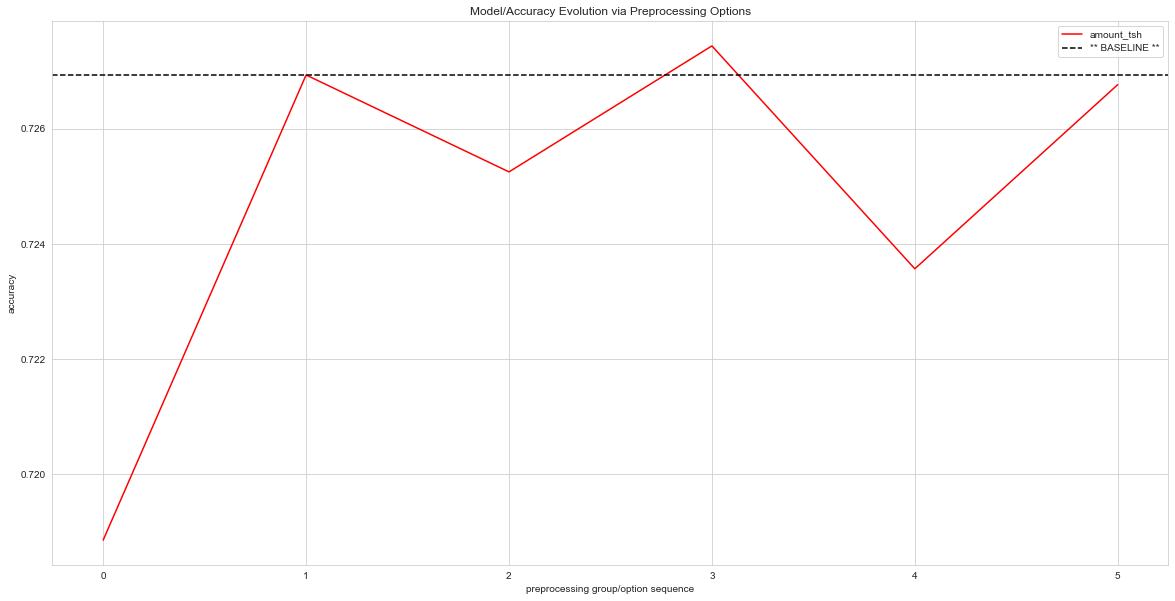

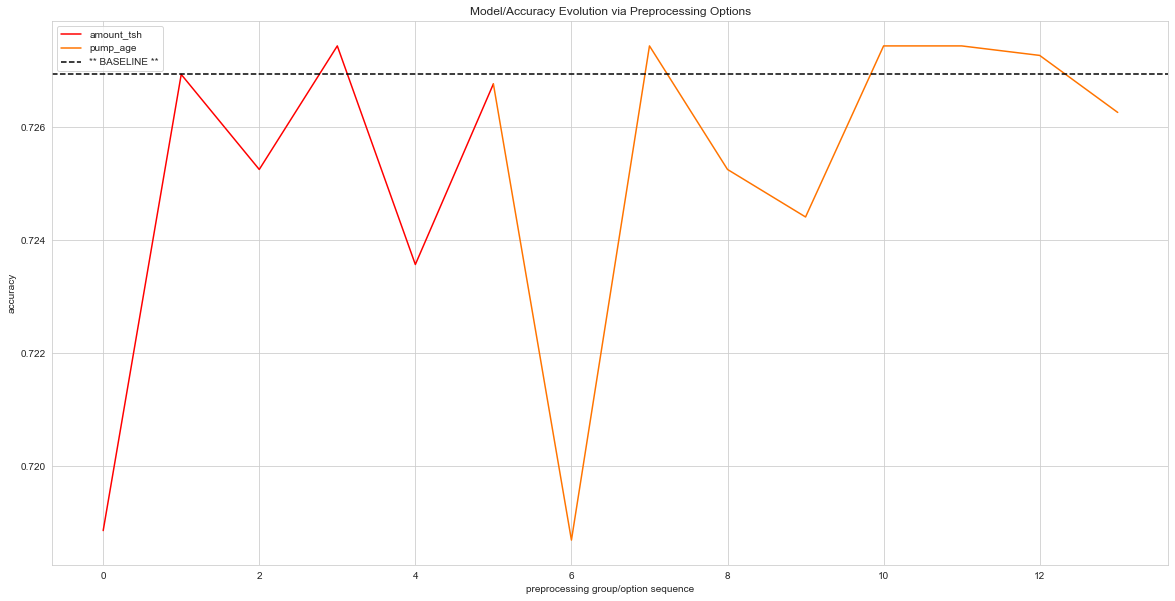

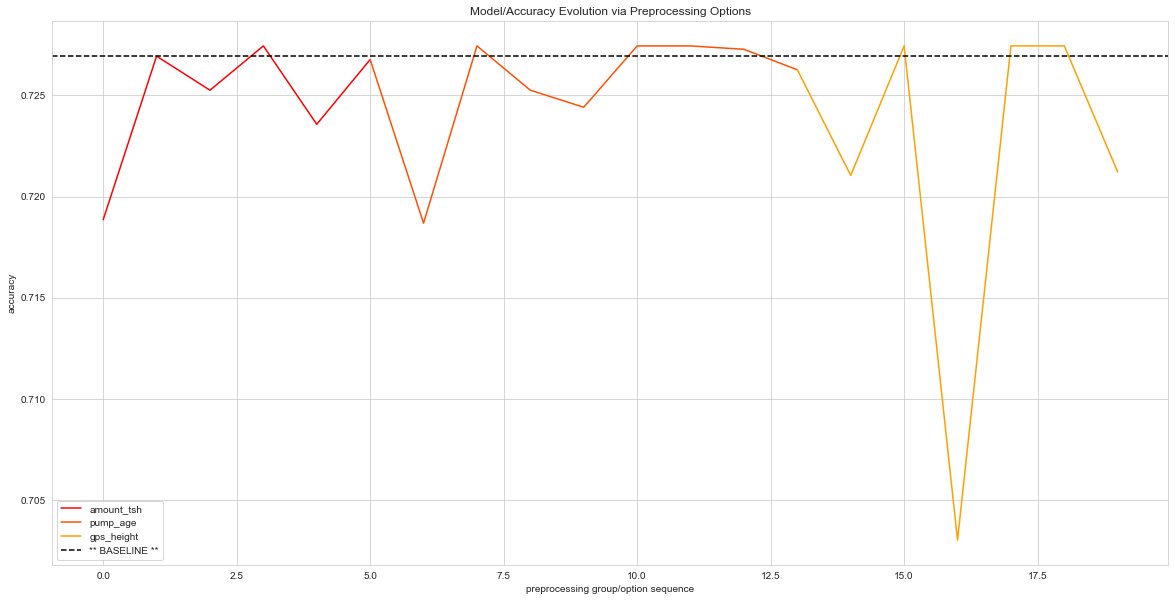

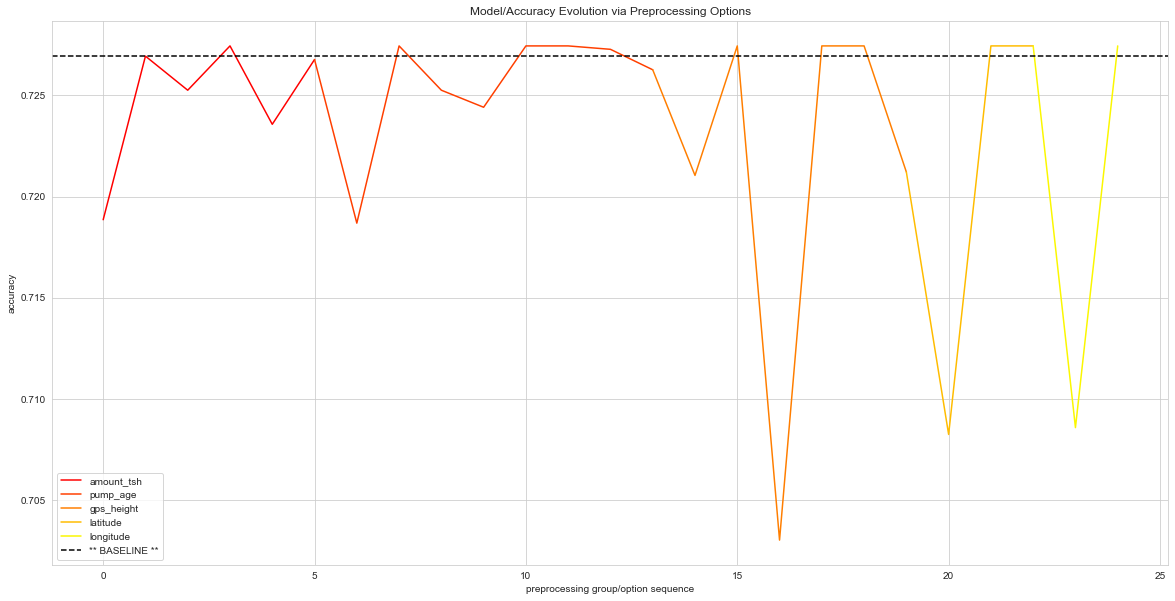

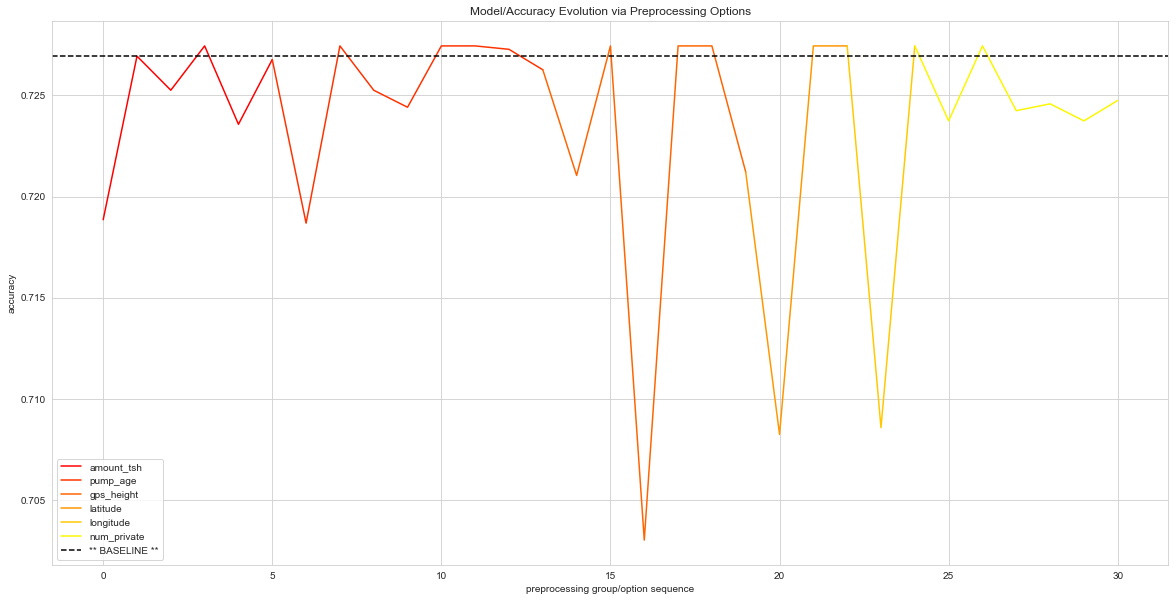

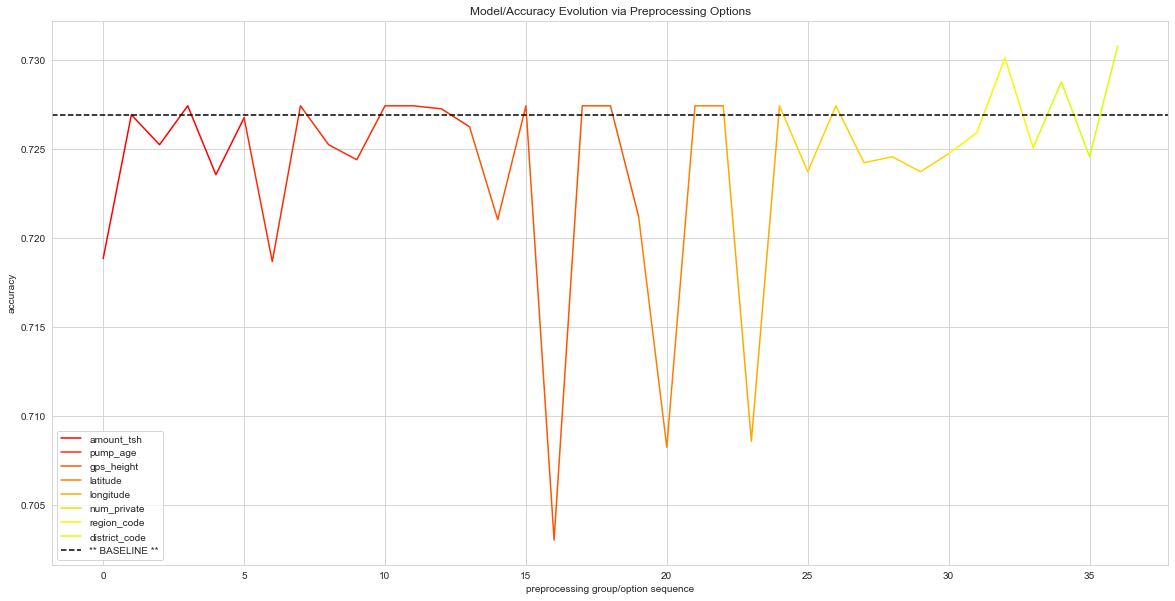

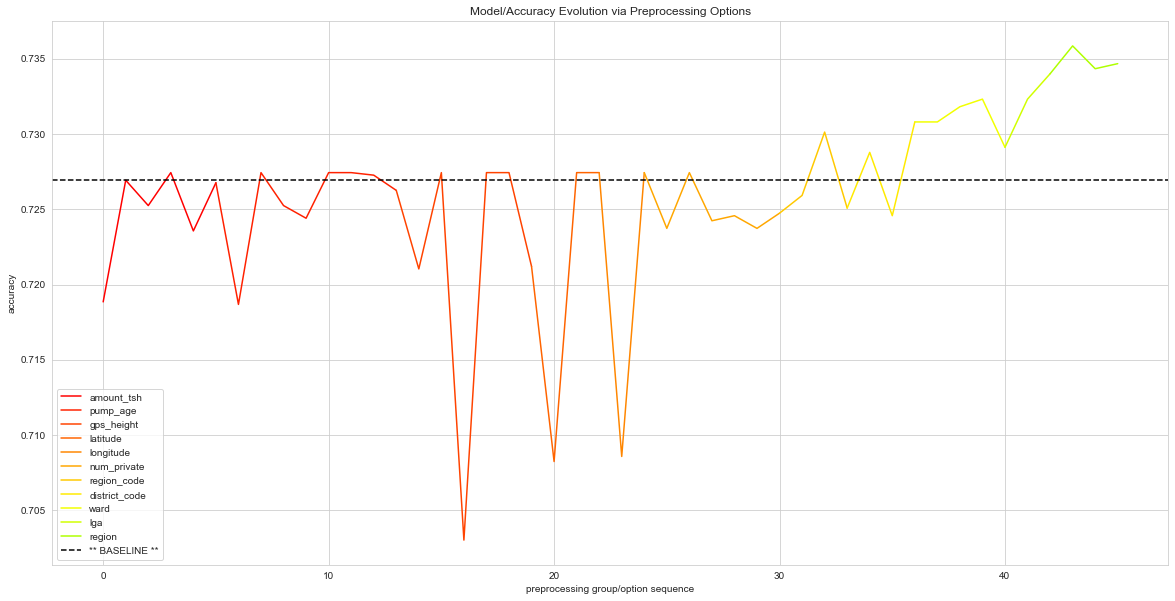

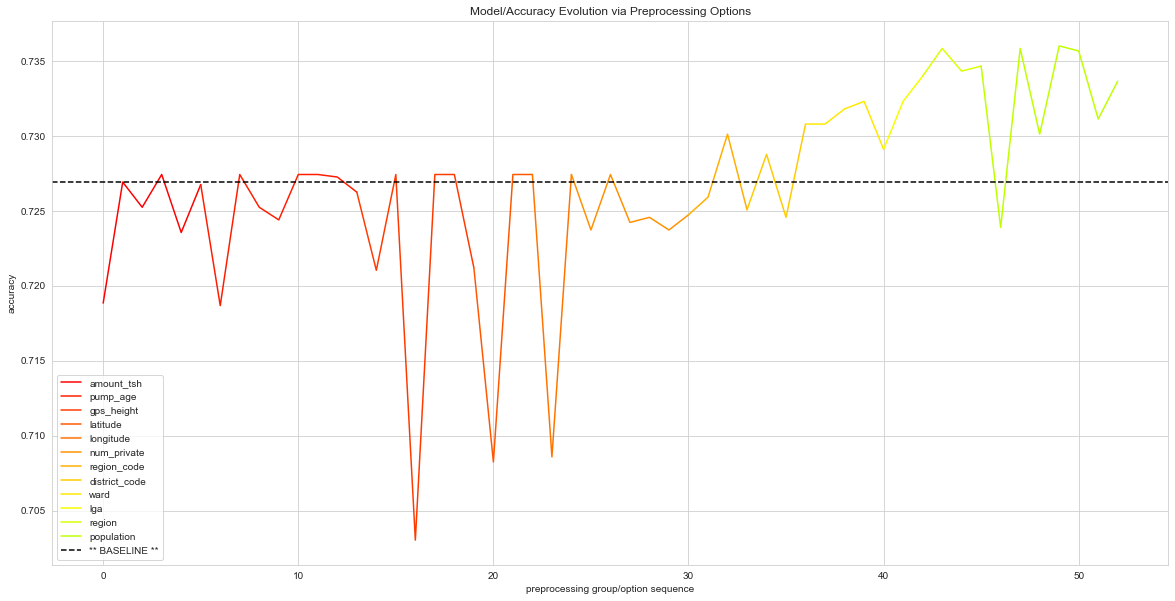

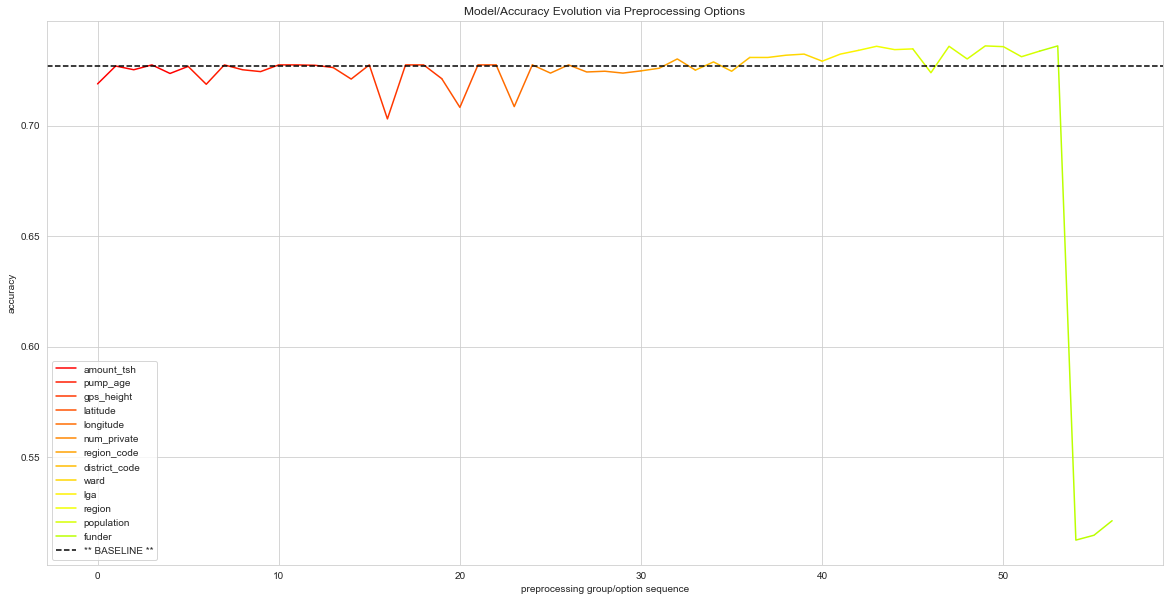

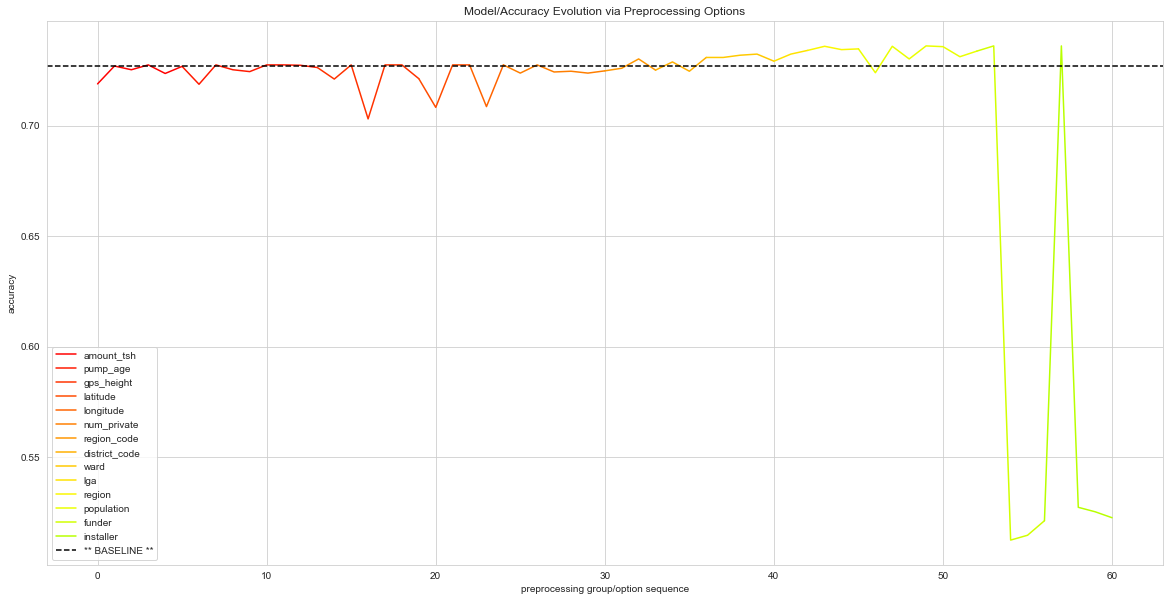

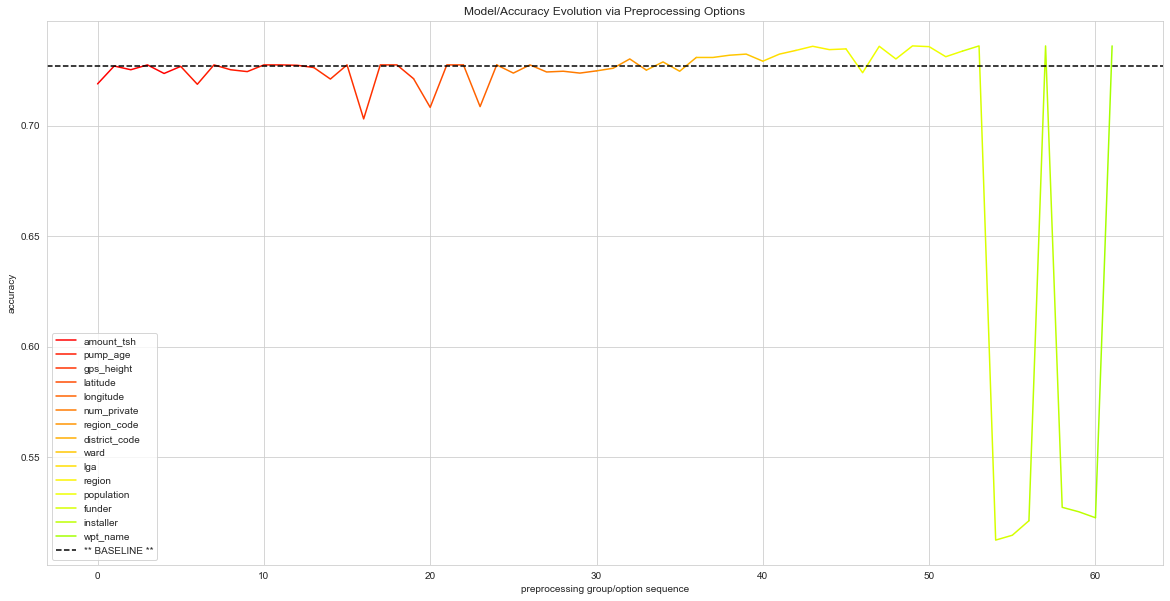

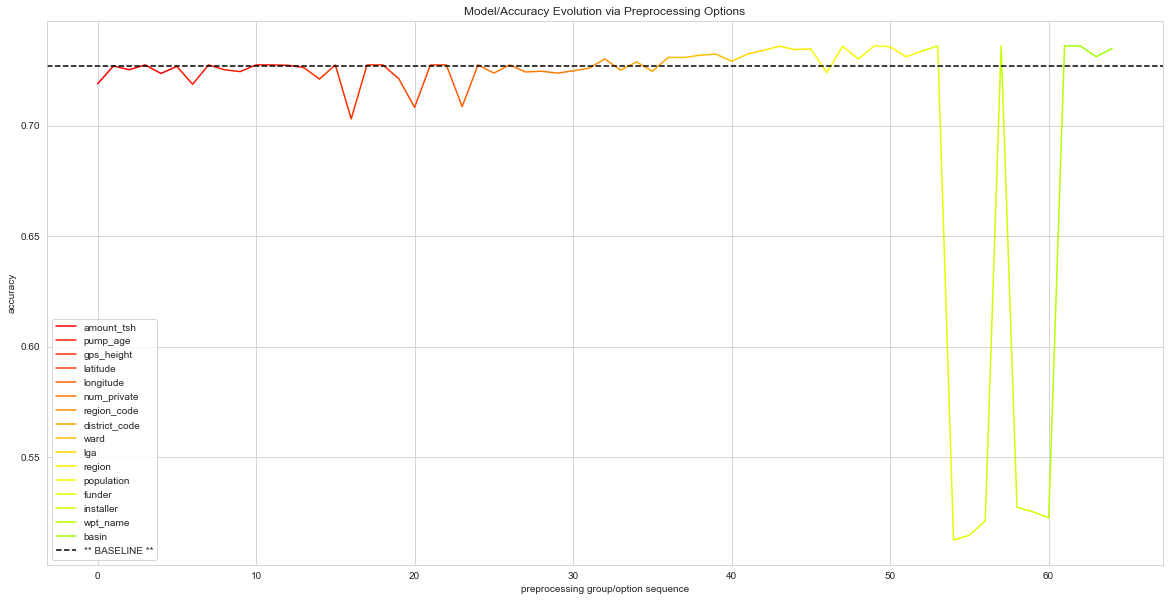

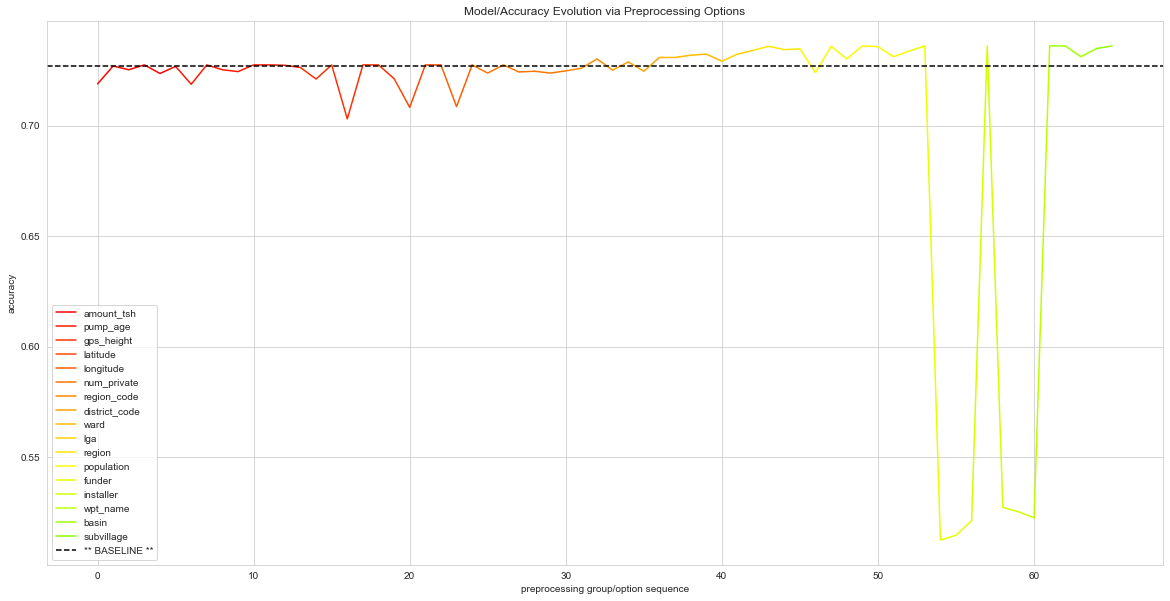

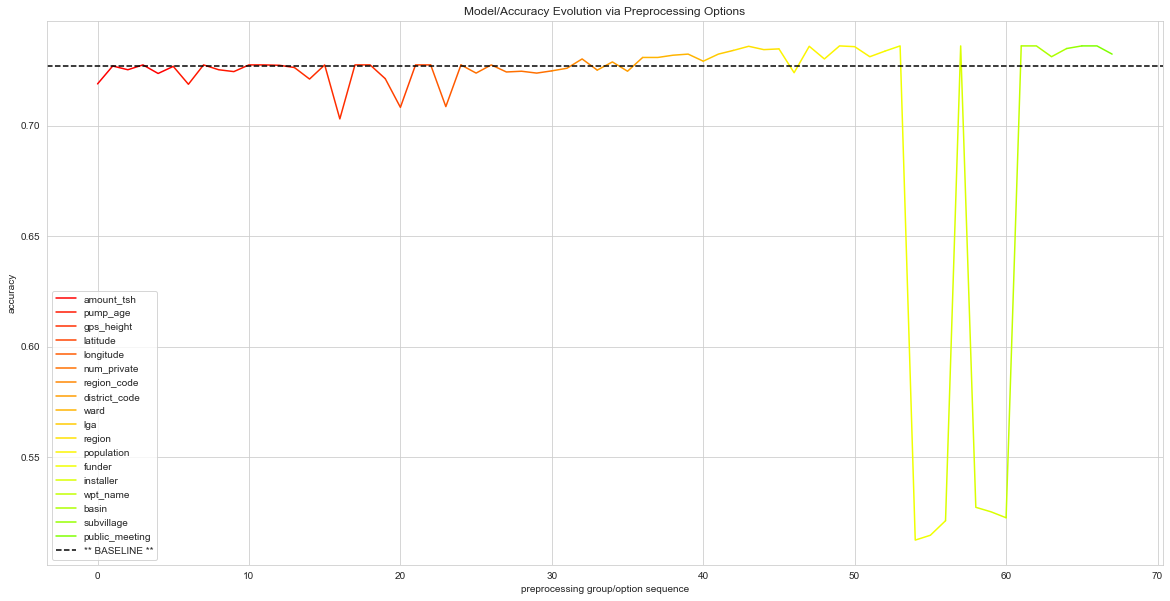

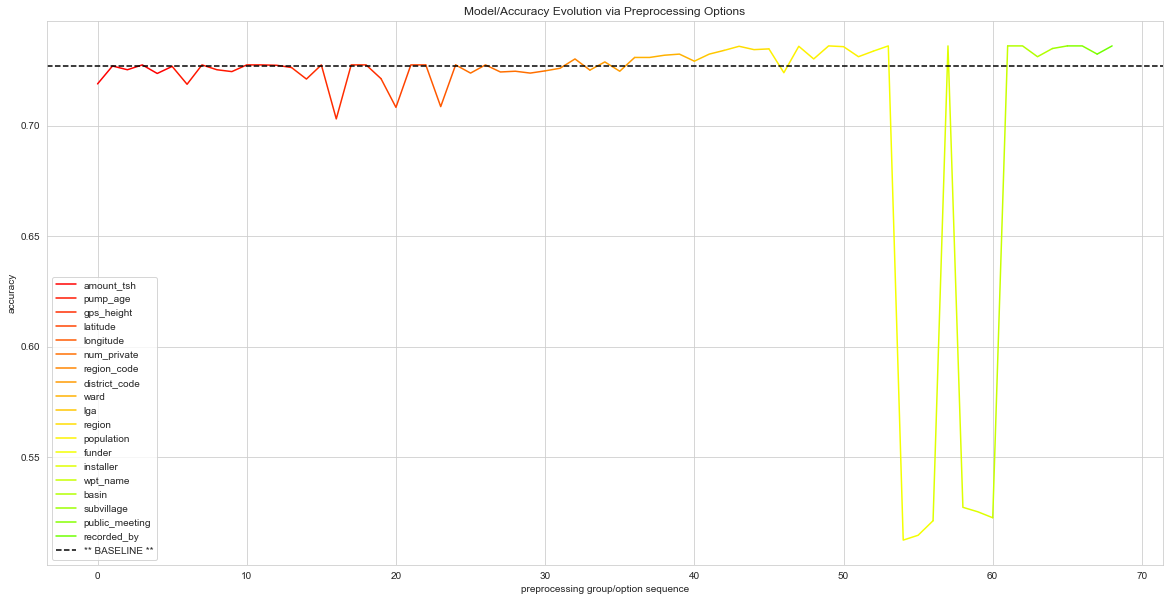

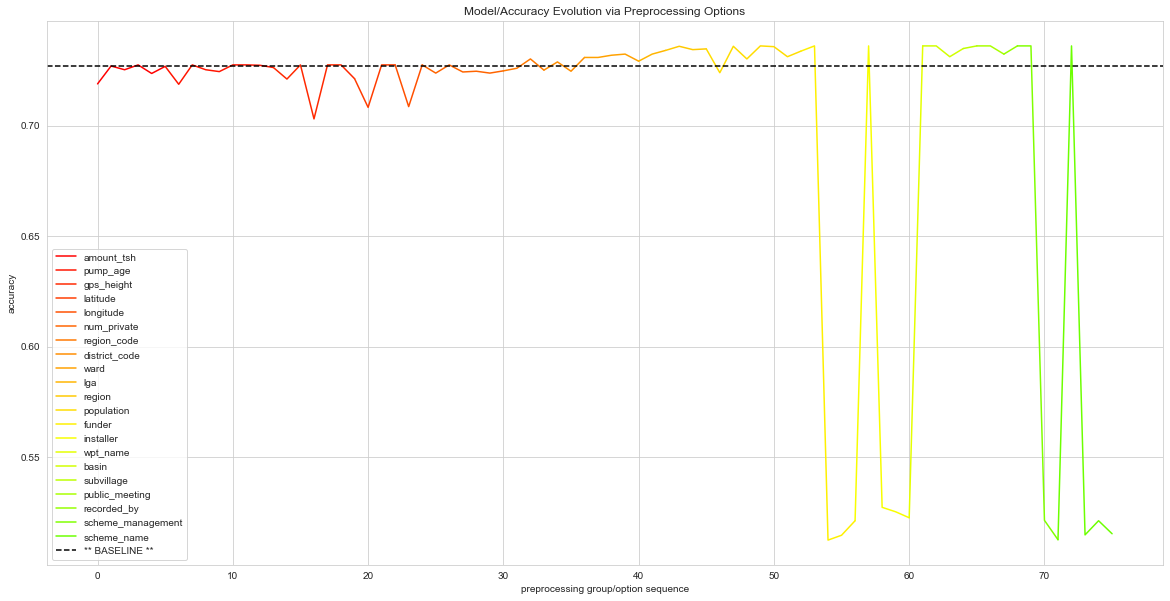

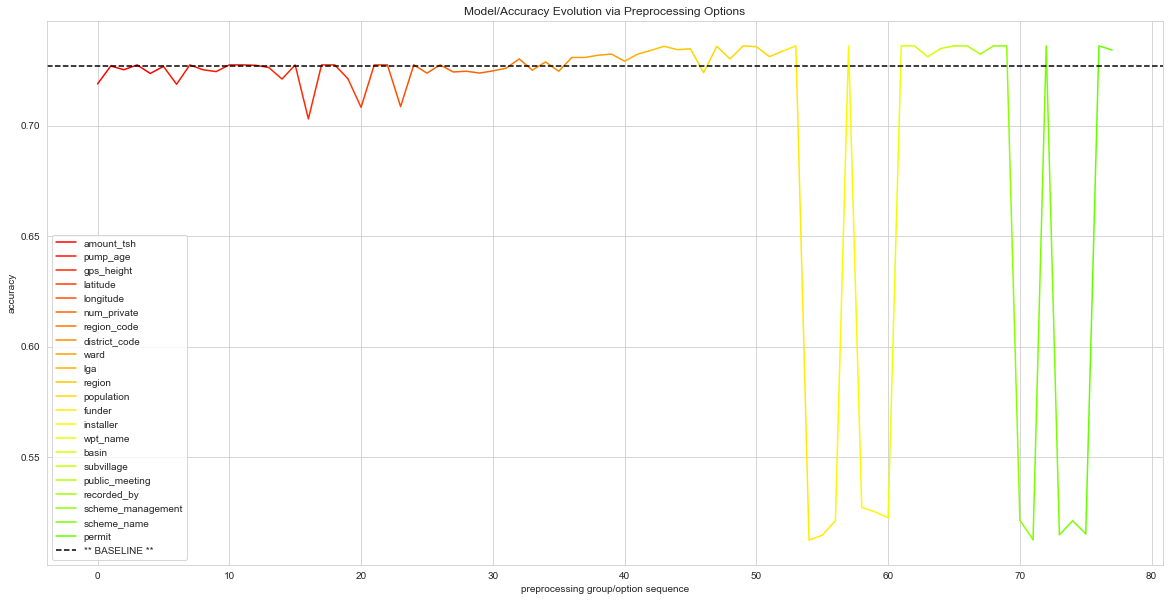

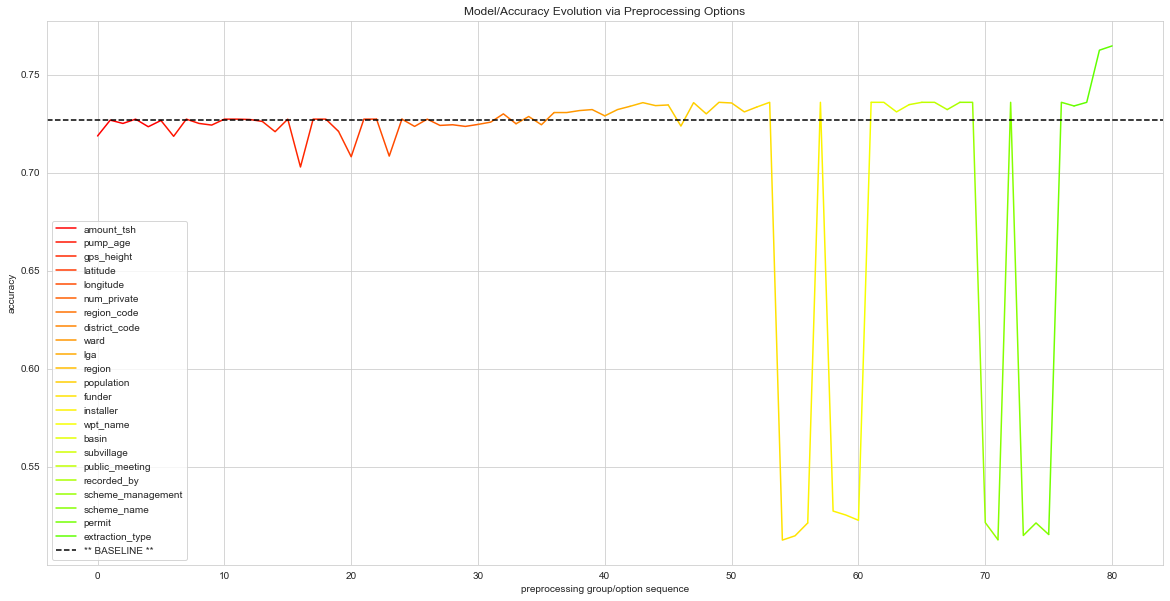

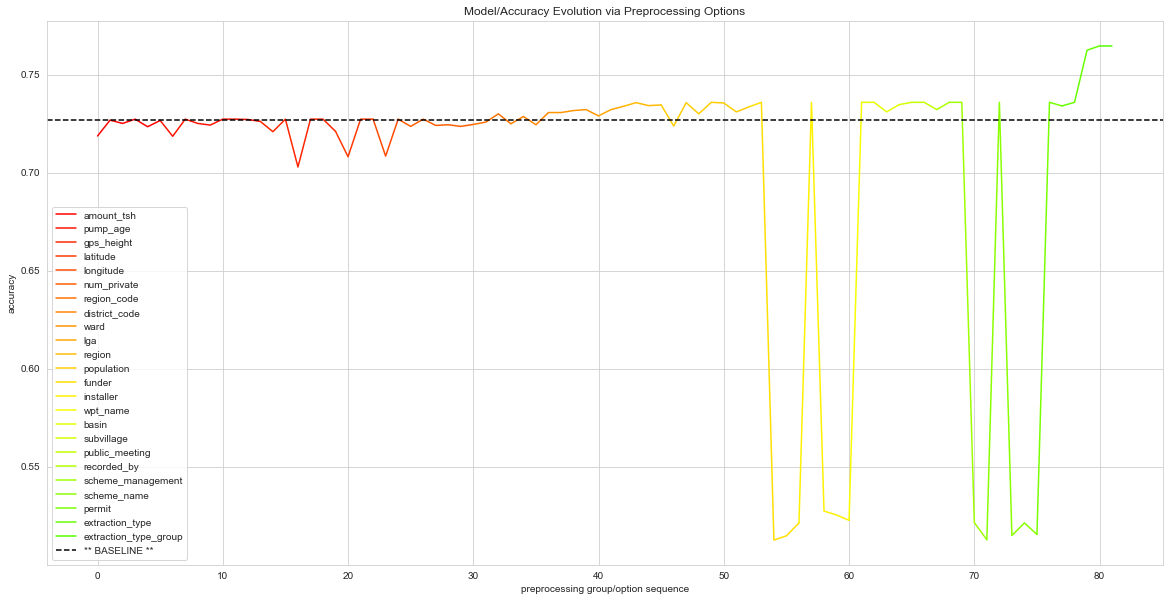

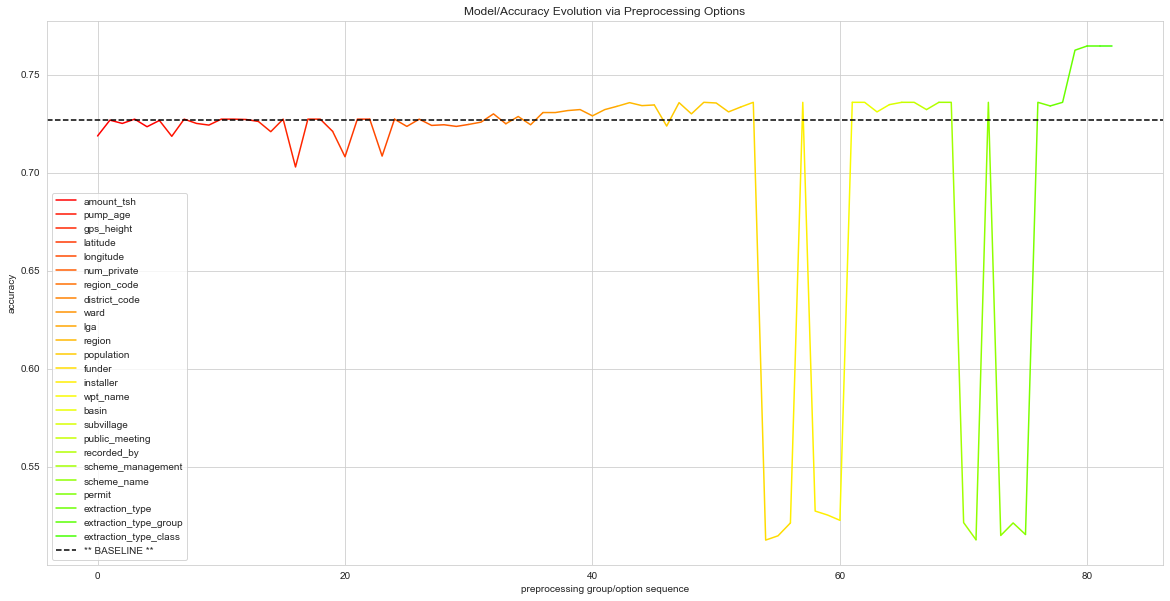

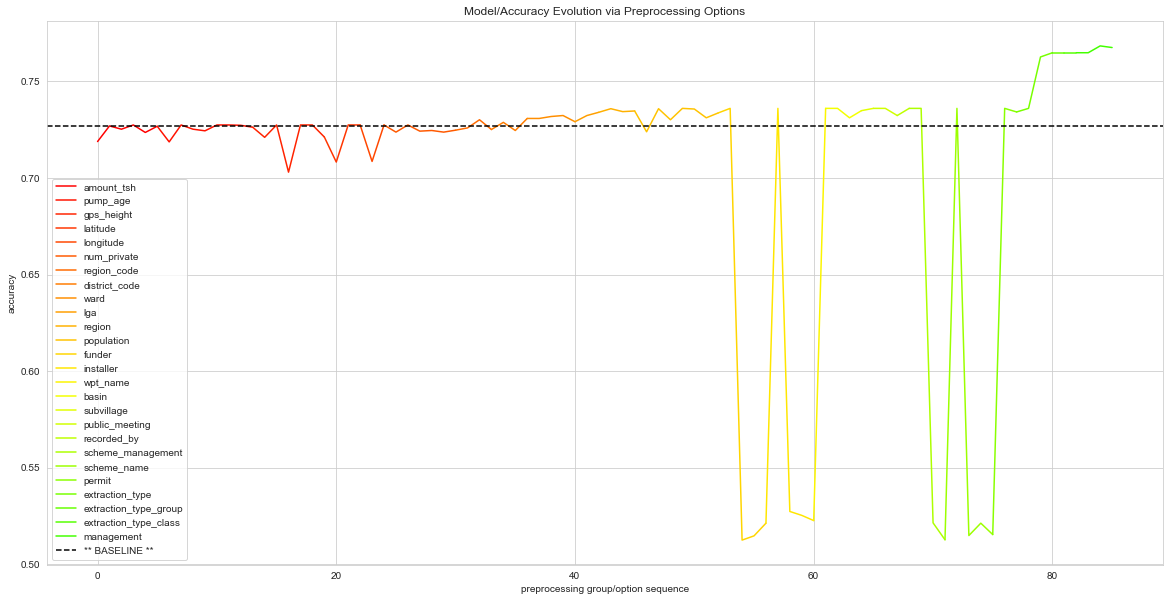

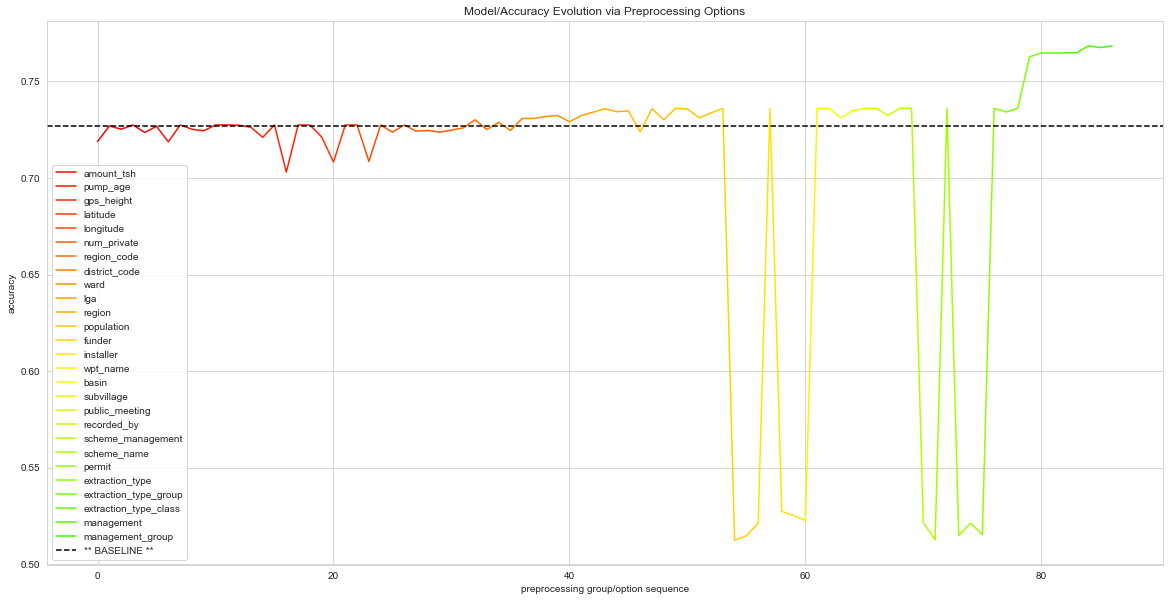

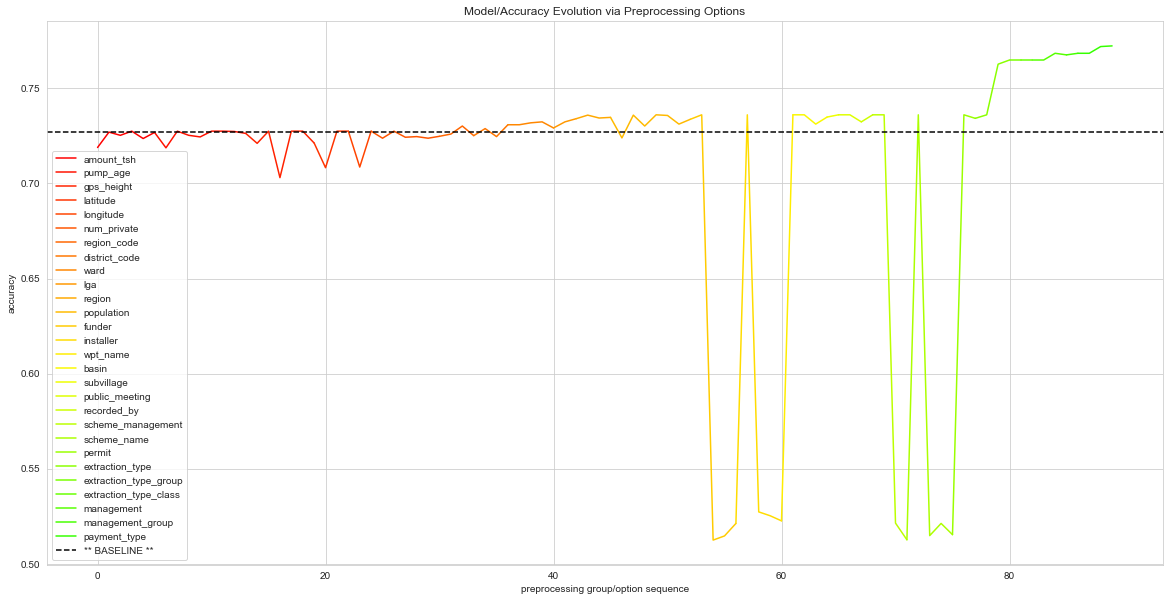

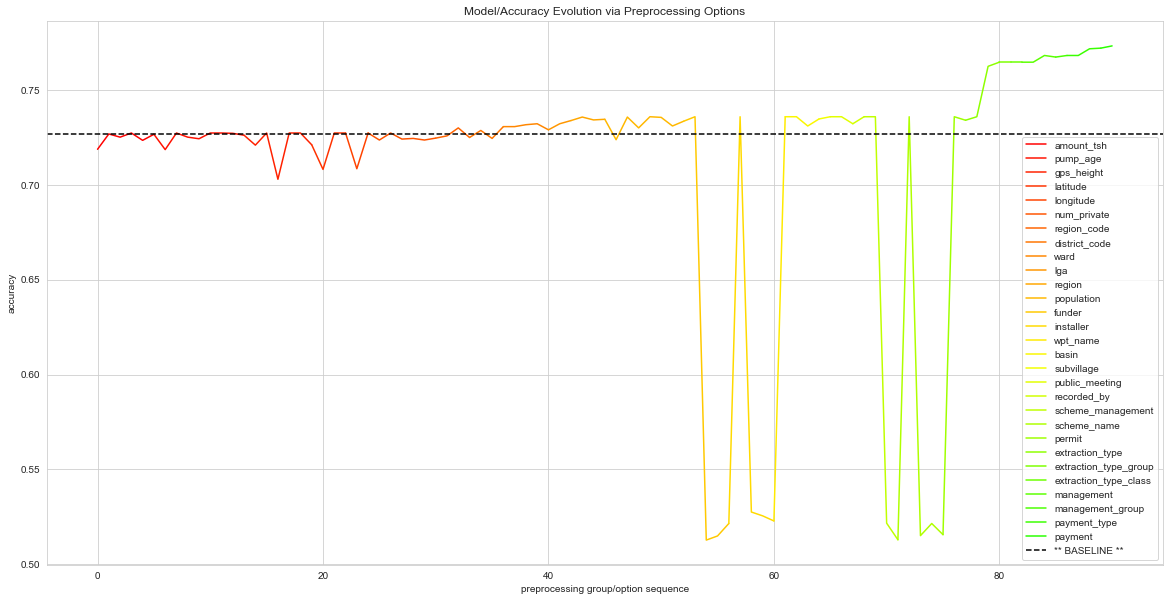

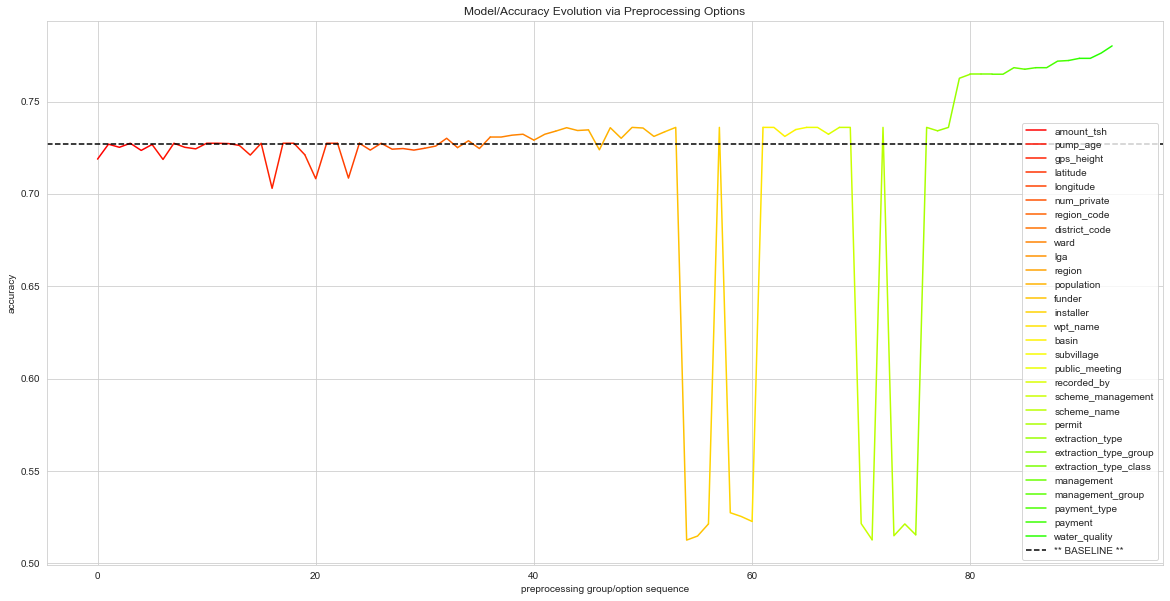

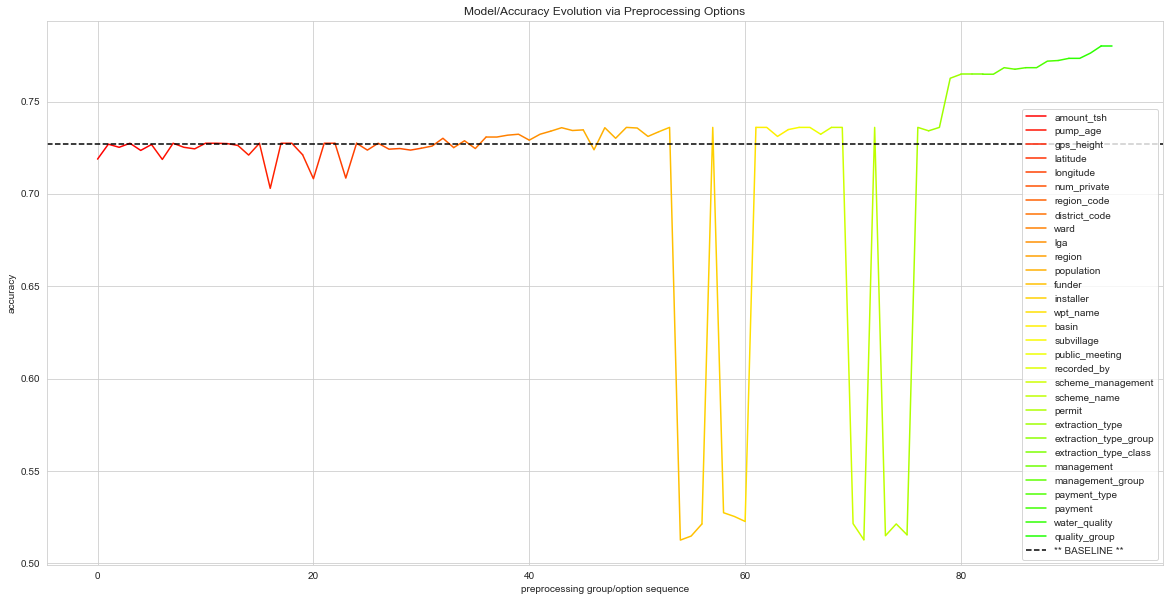

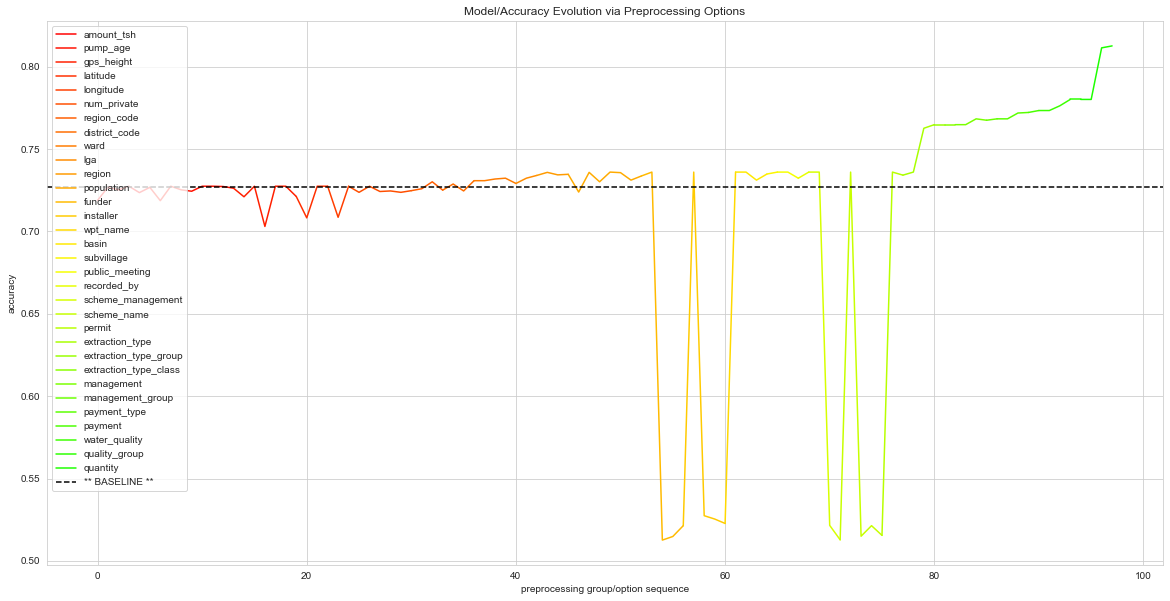

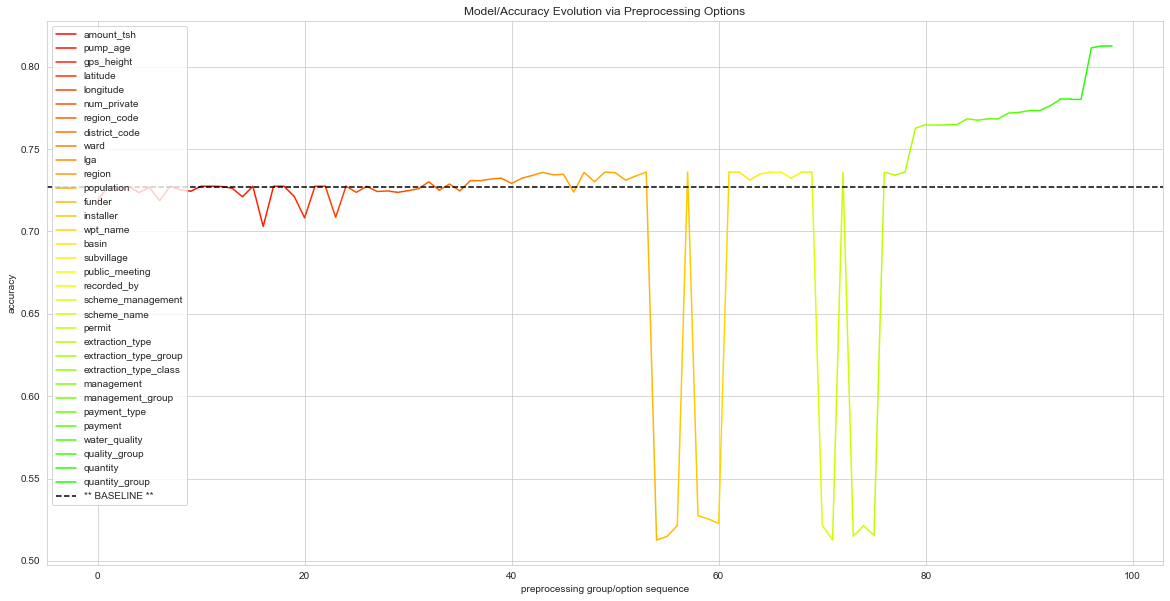

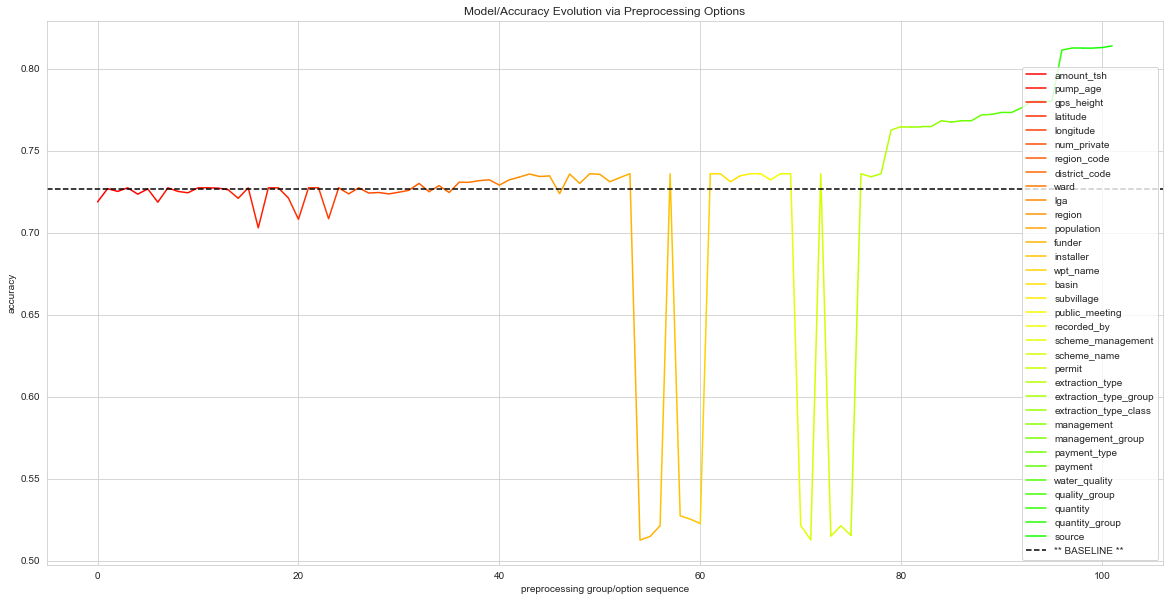

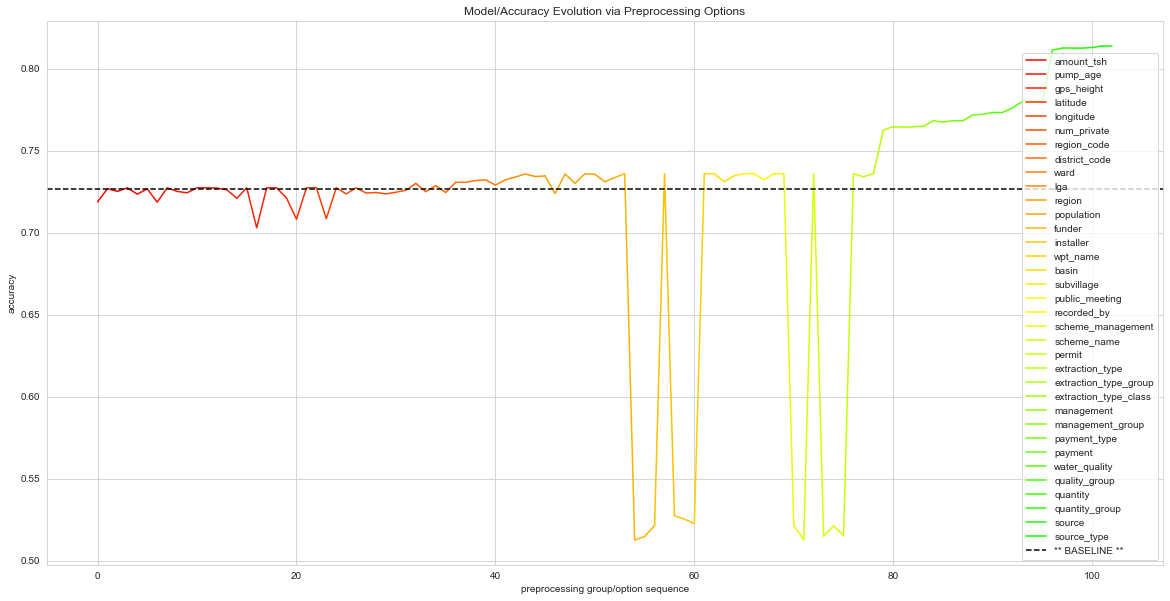

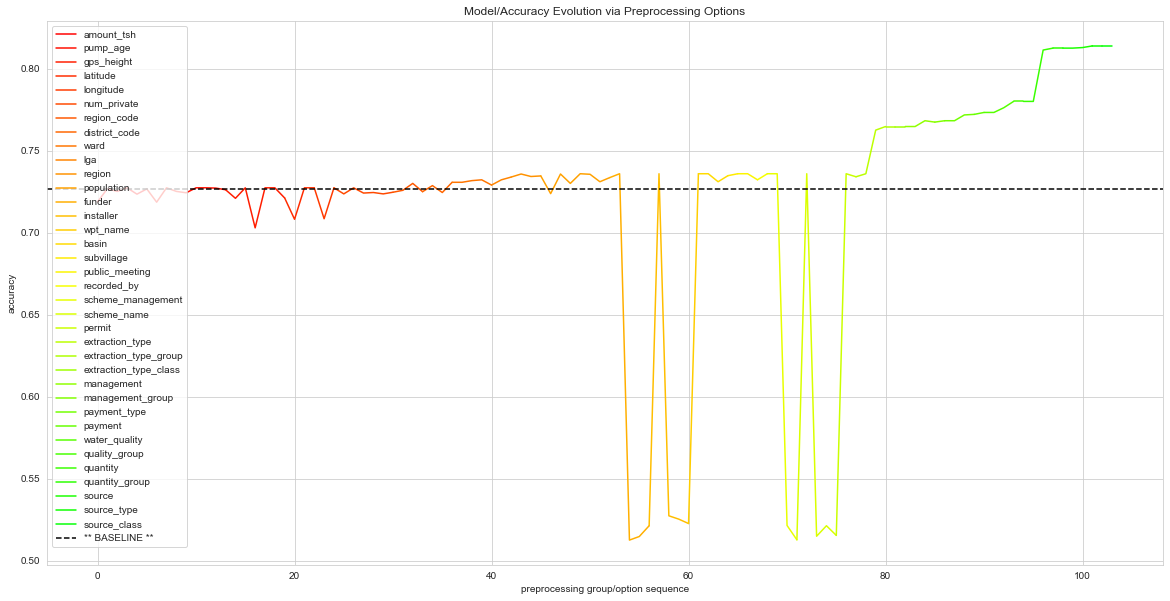

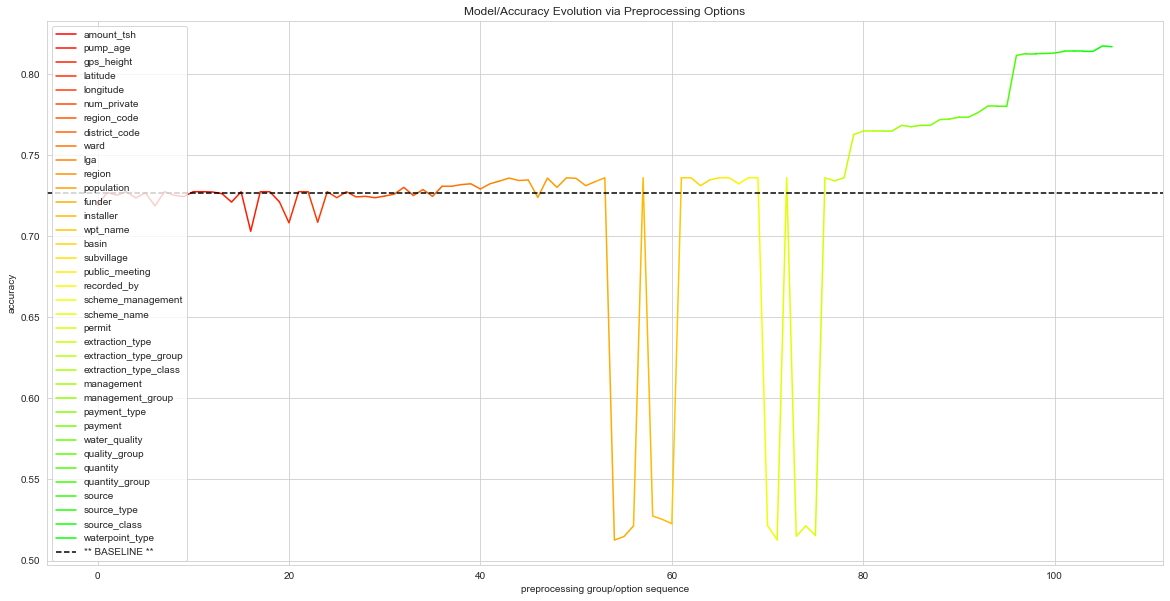

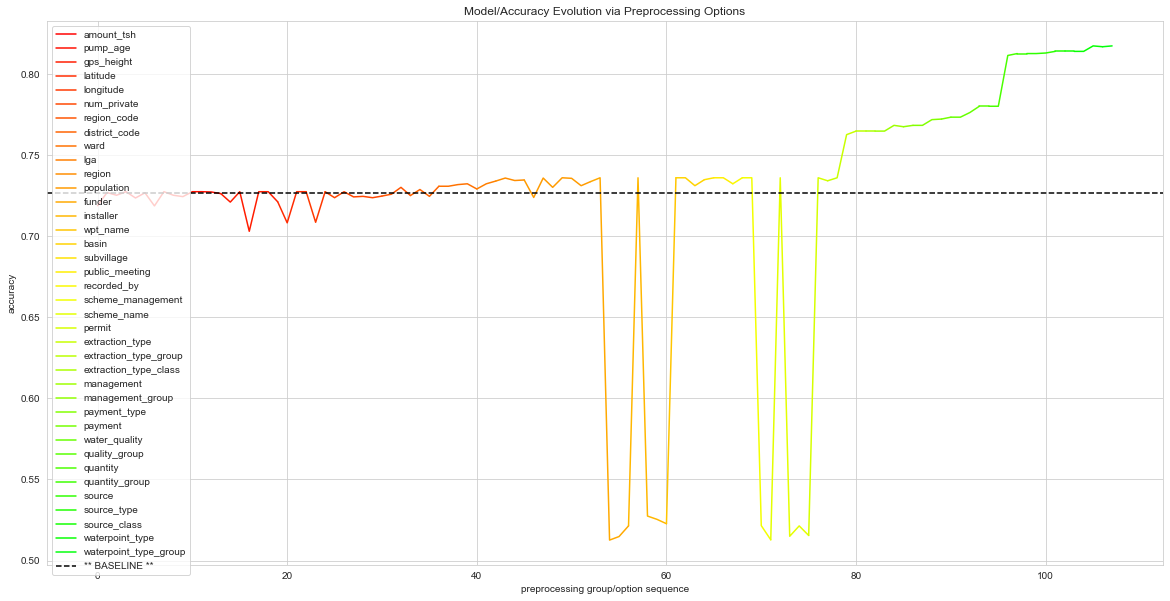

In [25]:
def get_cmap(n, name='hsv'):
    # from https://stackoverflow.com/a/25628397
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# hold baseline cols fixed until every other preprocessing option not involving a baseline col is complete
#    so with the following, we can ensure preprocessing options transforming baseline cols occur last
feat_groups_not_containing_baseline_cols = []
feat_groups_containing_baseline_cols = []
for feat_group_name in preprocessing_config['feature_groupings']:
    feats_in_group = preprocessing_config['feature_groupings'][feat_group_name]['features']
    contains_baseline_col = False
    for feat in feats_in_group:
        if feat in baseline_cols:
            contains_baseline_col = True
            break
    if not contains_baseline_col:
        feat_groups_not_containing_baseline_cols.append(feat_group_name)
    else:
        feat_groups_containing_baseline_cols.append(feat_group_name)   

best_options = []
y_acc = []
# for feat_group_name in preprocessing_config['feature_groupings']:
for feat_group_name in feat_groups_containing_baseline_cols+feat_groups_not_containing_baseline_cols:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    # the order of the group can matter - for instance when there may be some interaction between a feat occurring earlier and one occuring later 
    #    so we need to permute all different orderings and take the best permutation
    orderings = list(itertools.permutations(preprocessing_options.keys(), len(preprocessing_options)))
    if len(orderings) > 1:
        display(HTML(f"<p><br><font style='font-size: x-large;'>Feature-group <i><font color='red'>{feat_group_name}</font></i> has {len(preprocessing_options)} preprocessing-groups; there are therefore {len(orderings)} different orderings of those {len(preprocessing_options)} preprocessing-groups to iterate...</font>"))

    best_option = None      # structure: (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
    best_ending_acc = None
    for i_ordering, ordering in enumerate(orderings):
        _best_options = best_options.copy()
        _y_acc = y_acc.copy()

        for preprocessing_group_name in ordering:
            opts_for_group = preprocessing_options[preprocessing_group_name]
            _best_option, _y_acc = find_best_option(feat_group_name, preprocessing_group_name, _best_options, _y_acc, i_ordering=i_ordering if len(orderings)>1 else None)
            _best_options.append(_best_option)
                
        if best_ending_acc is None or _y_acc[-1]['acc'][-1] > best_ending_acc[1][-1]['acc'][-1]:
            best_ending_acc = (i_ordering, _y_acc, _best_options)

    # use the best options of all orderings for this feature-group
    best_options = best_ending_acc[2]
    y_acc = best_ending_acc[1]
    
    # show summary of the best for the last feature-group only
    short_best_opts = [(bo[0], bo[1]) for bo in best_options[len(best_options)-len(preprocessing_options):]]
    display(HTML(f"<p><br><font style='font-size: x-large;'>Best options for feature group <i><font color='red'>{feat_group_name}</font>:</font></i><br><pre>{short_best_opts}</pre>"))

    # but now plot entire history at the end of each feature-group
    display(HTML("<p><br>"))
    plt.figure(figsize=(20,10))
    x_offset = 0
    cmap = get_cmap(sum(list(map(lambda y_acc_item: len(y_acc_item['acc']), y_acc))))
    for i, y_acc_item in enumerate(y_acc):
        xs = list(range(x_offset, x_offset+len(y_acc_item['acc'])))
        ys = y_acc_item['acc']
        if i > 0: # prepend acc of last item from last list so we don't have any discontinuity in plot
            xs = [x_offset-1] + xs
            ys = [y_acc[i-1]['acc'][-1]] + ys
        plt.plot(xs, ys, c=cmap(i), label=y_acc_item['ppgn'])
        x_offset += len(y_acc_item['acc'])
        
    plt.axhline(y=_accuracy_validation_baseline, linestyle='--', color="black", label='** BASELINE **')
    
    plt.xlabel('preprocessing group/option sequence')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Model/Accuracy Evolution via Preprocessing Options')
    plt.show()
    
    long_best_opts = [(bo[0], bo[1]) for bo in best_options]
    display(HTML(f"<p><br><font style='font-size: x-large;'>Summary of best-options history:</font></i><br><pre>{long_best_opts}</pre>"))

    display(HTML("<p><br><br><br><br>"))

<p><br><br><br><br>

## Test Best Preprocessing Options Transformations on `X_train`

In [26]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [27]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnpreprocessing.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnpreprocessing.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

In [28]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [29]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'amount_tsh': [['amount_tsh',
   'C__replace_outliers_with_mean__StrategyTransformer']],
 'pump_age': [['date_recorded', 'C__drop_it__StrategyTransformer'],
  ['construction_year', 'C__leave_it_as_is__StrategyTransformer']],
 'gps_height': [['gps_height', 'C__leave_it_as_is__StrategyTransformer']],
 'latitude': [['latitude', 'C__leave_it_as_is__StrategyTransformer']],
 'longitude': [['longitude', 'C__leave_it_as_is__StrategyTransformer']],
 'num_private': [['num_private', 'C__leave_it_as_is__StrategyTransformer']],
 'region_code': [['region_code',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'district_code': [['district_code',
   'C__OneHotEncode__district_code__StrategyTransformer']],
 'ward': [['ward', 'C__tfidf_normalize__ward__StrategyTransformer'],
  ['ward',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'lga': [['lga',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTra

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_validation`

In [30]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [31]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

In [32]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_unlabeled`

In [33]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [34]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

In [35]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

## Save Best Preprocessing Options (as Preprocessing Spec) to File

In [36]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [37]:
fname__best_options_cfg, fname__last_preprocessing_spec = scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
fname__best_options_cfg = WRANGLED_DATA_DIR + fname__best_options_cfg
fname__last_preprocessing_spec = WRANGLED_DATA_DIR + fname__last_preprocessing_spec
print(f"best preprocessing options config will be saved to: {fname__best_options_cfg}")
print(f"best preprocessing options config will be saved as last preprocessing spec to: {fname__last_preprocessing_spec}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-8a48b1bceea8e4f07957e8a9efbe76d8.json
best preprocessing options config will be saved as last preprocessing spec to: preprocessing-results/preprocessing-spec-last.json


In [38]:
fm.save_json(best_preprocessing_config, f"{fname__best_options_cfg}")
print(f"updated {fname__best_options_cfg}")

# also save canonical for model building
fm.save_json(best_preprocessing_config, f"{fname__last_preprocessing_spec}")
print(f"updated {fname__last_preprocessing_spec}")

updated preprocessing-results/preprocessing-options-8a48b1bceea8e4f07957e8a9efbe76d8.json
updated preprocessing-results/preprocessing-spec-last.json


# Conclusion

We're now ready to move on to the final model building stage.